# EE-411 Fundamentals of inference and learning

## Exercise session 13: Denoising with autoencoders & K-means

**What you will learn today:** In this notebook, we will learn the basics of denoising and generative models. We consider one of the most important architecture: denoising autoencoders. In the blast section at the end you will find few question about K-means algorithm!

## Denoising with auto-encoders

As usual we consider our favourit (and easiest to run) MNIST dataset. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import os 
import math
## torch imports ##
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# define the hyperparameters
BATCH_SIZE = 64
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.01
EPOCHS = 20
# choose MSE loss
LOSS = nn.MSELoss()
# find out which device is available
DEVICE = torch.device("mps") 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


We will use only a small portion of MNIST for this tutorial as we know that the qualitative claims will be left unchanged. 


Let's load the dataset and create the dataloader.

In [3]:
transform = torchvision.transforms.ToTensor()

# load the train dataset

## use only 30% of the dataset for training ##
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_dataset, _ = random_split(train_dataset, [int(len(train_dataset)*0.1), int(len(train_dataset)*0.9)])

# load the test dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# create the data loaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

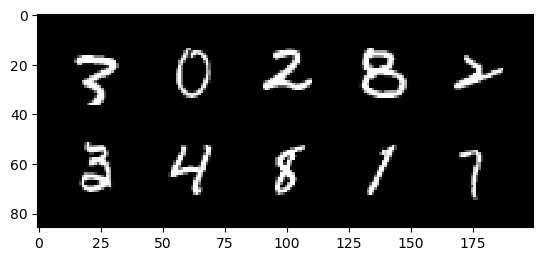

In [4]:
def visualize_images(dataloader):
    images = next(iter(dataloader))[0][:10]
    grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

    def show(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")

    show(grid)

visualize_images(train_dataloader)

### Creating the denoising autoencoder

In [5]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(1568, 128),
            nn.ReLU(True),
            nn.Linear(128, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 1568),
            nn.ReLU(True),
            nn.Unflatten(1, (32, 7, 7)),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encode
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)
        return decoded


### Initialize models, loss, parameters

In [6]:
# Instantiate the Denoising Autoencoder model
latent_dim = 32 
denoising_autoencoder = DenoisingAutoencoder(latent_dim)
# Define the optimizer
params_to_optimize = denoising_autoencoder.parameters()
optim = torch.optim.Adam(params_to_optimize, lr = LEARNING_RATE)
# Train the model
denoising_autoencoder.to(DEVICE)

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1568, out_features=128, bias=True)
    (10): ReLU(inplace=True)
    (11): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=1568, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(di

### Training

Introducing the clipping procedure to create the corrupted images.

In [7]:
### function to add a given noise_factor to the image ###
def corruption(img,noise_factor):
     noisy_img = img + torch.randn_like(img)*noise_factor
     noisy_img = torch.clip(noisy_img, 0., 1.)
     return noisy_img

In [8]:
### appply encoder to check shapes of one image ###
img = next(iter(train_dataloader))[0][0]
img = img.to(DEVICE)
img = img.unsqueeze(0)
print(img.shape)
encoded_img = denoising_autoencoder.encoder(img)
print(encoded_img.shape)
decoded_img = denoising_autoencoder.decoder(encoded_img)
print(decoded_img.shape)


torch.Size([1, 1, 28, 28])
torch.Size([1, 32])
torch.Size([1, 1, 28, 28])


#### Your turn
Try to write the training epoch function for a denoising autoencoder. Remember, what we are trying to learn is not anymore the label itself, but the image starting from a noisy version of it! In other words, we are trying to reconstruct! Look at the function we used last time in *training_utils.py*, it will help!

In [11]:
# write training_epoch function for denoising autoencoder
def training_epoch(denoising_autoencoder, device, dataloader, loss_func, optimizer, noise_factor):
    denoising_autoencoder.train()
    train_loss = []
    for image_batch, _ in dataloader: 
        image_batch = image_batch.to(device)
        noisy_image_batch = corruption(image_batch, noise_factor)
        optimizer.zero_grad()
        reconstructed_image_batch = denoising_autoencoder(noisy_image_batch)
        loss = loss_func(reconstructed_image_batch, image_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    return np.mean(train_loss)

Epoch: 1 	Training Loss: 0.012238


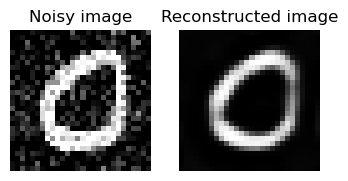

Epoch: 2 	Training Loss: 0.011963
Epoch: 3 	Training Loss: 0.011788
Epoch: 4 	Training Loss: 0.011503
Epoch: 5 	Training Loss: 0.011355
Epoch: 6 	Training Loss: 0.011265


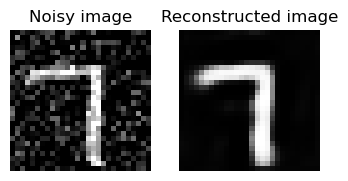

Epoch: 7 	Training Loss: 0.010942
Epoch: 8 	Training Loss: 0.010888
Epoch: 9 	Training Loss: 0.010543
Epoch: 10 	Training Loss: 0.010501
Epoch: 11 	Training Loss: 0.010469


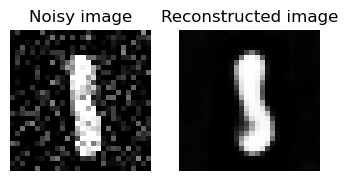

Epoch: 12 	Training Loss: 0.010263
Epoch: 13 	Training Loss: 0.009998
Epoch: 14 	Training Loss: 0.009905
Epoch: 15 	Training Loss: 0.009793
Epoch: 16 	Training Loss: 0.009621


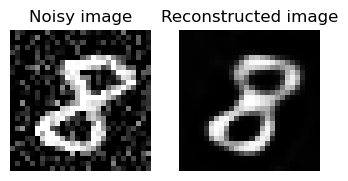

Epoch: 17 	Training Loss: 0.009686
Epoch: 18 	Training Loss: 0.009576
Epoch: 19 	Training Loss: 0.009448
Epoch: 20 	Training Loss: 0.009274


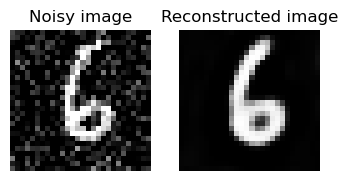

In [13]:
noise_factor = 0.2
for epoch in range(EPOCHS):
    train_loss = training_epoch(denoising_autoencoder, DEVICE, train_dataloader, LOSS, optim, noise_factor)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))
    if epoch % 5 == 0 or epoch == EPOCHS-1:
        # plot the noisy image and the reconstructed one for 5 images of the training set 
        img = next(iter(train_dataloader))[0][0]
        img = img.unsqueeze(0)
        img_noisy = corruption(img, noise_factor)
        img_noisy = img_noisy.to(DEVICE)
        img_reconstructed = denoising_autoencoder(img_noisy)
        ### plot the noisy image and the reconstructed one for one image of the training set with small figure size ###
        plt.figure(figsize=(4,2))
        plt.subplot(1,2,1)
        plt.imshow(img_noisy.squeeze().cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.title('Noisy image')
        plt.subplot(1,2,2)
        plt.imshow(img_reconstructed.squeeze().detach().cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed image')
    
        plt.show()


### Studying the latent space of a denoising autoencoder 

After the encoding step we obtain a *low-dimensional* representation of our dataset. This low-dimensional space is called *latent space*. Let us analyze with the different tools of the previous lectures this low-dimensional subspace. 

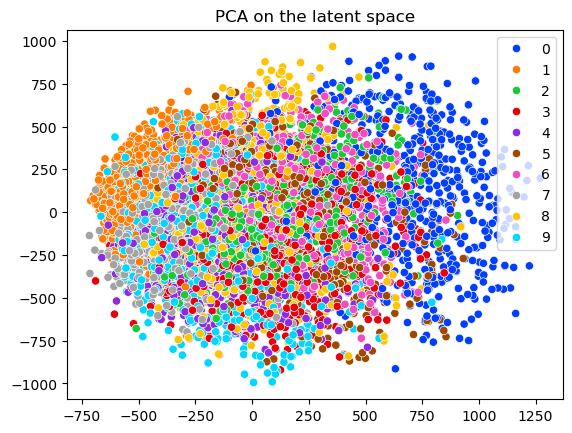

In [15]:
### perform PCA on the latent space of the autoencoder visualizing with color labels for different digits ###
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

def plot_latent_space(model, device, dataloader):
    model.eval()
    latent_vectors = []
    labels = []
    for image_batch, label_batch in dataloader:
        image_batch = image_batch.to(device)
        latent_vector = model.encoder(image_batch).detach().cpu().numpy()
        latent_vectors.append(latent_vector)
        labels.append(label_batch.numpy())
    latent_vectors = np.concatenate(latent_vectors)
    labels = np.concatenate(labels)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(latent_vectors)
    sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 10))
    plt.title('PCA on the latent space')
    plt.show()
    return pca_result

pca_result = plot_latent_space(denoising_autoencoder, DEVICE, train_dataloader)

We can grasp a clustered structure but it is not satisfying. Let us try some non-linear dimensionality reduction tool, e.g., t-SNE. 

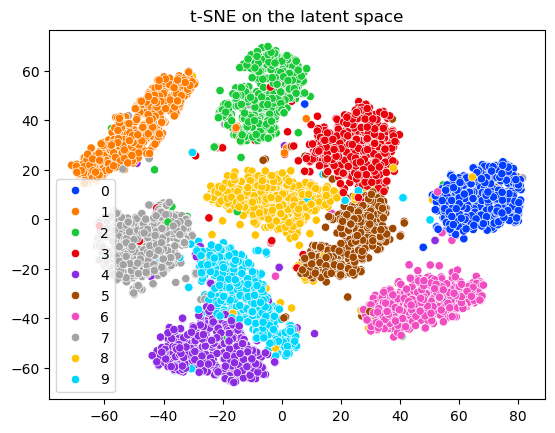

In [16]:
### perform the same using t-SNE ### 

def plot_latent_space_tsne(model, device, dataloader):
    model.eval()
    latent_vectors = []
    labels = []
    for image_batch, label_batch in dataloader:
        image_batch = image_batch.to(device)
        latent_vector = model.encoder(image_batch).detach().cpu().numpy()
        latent_vectors.append(latent_vector)
        labels.append(label_batch.numpy())
    latent_vectors = np.concatenate(latent_vectors)
    labels = np.concatenate(labels)
    tsne = TSNE(n_components=2)
    tsne_result = tsne.fit_transform(latent_vectors)
    sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 10))
    plt.title('t-SNE on the latent space')
    plt.show()
    return tsne_result

tsne_result = plot_latent_space_tsne(denoising_autoencoder, DEVICE, train_dataloader)


We see that with more sophisticated unsupervised learning strategy we are able to recognize groups according to the different digits! An interesting direction to explore is to analyze what happens when we enforce a certain structure on the latent space **during training**. This is the topic of Variational Autoencoders, for the mos curious of you, one can check: [https://arxiv.org/abs/1312.6114] and https://arxiv.org/pdf/1906.02691.pdf writen by Kingma and Welling who introduced first VAE.

## Clustering with K-means

Now we come back to scikit-learn to see how to easily implement K-means 

1) Generate K Gaussian clusters of $n$ samples. Each cluster has $n_k = n/K$ data points $\boldsymbol{x}^{\mu}_{i,k} \in \mathbb{R}^{d}$ of mean  $\mu_k \in \mathbb{R}^{d}$, and covariance matrix  $\Sigma = \sigma \mathbb{I}_{d\times d}$. Take $d = 2$. Plot the data points in the 2-dimensional space with their centroids and assign to each data point a color according to cluster membership.


_Hint_: for example, you can choose $n_k=100$, $K=3$ and $\sigma=1$. Try fixing some well-distanced centroids for this first part.

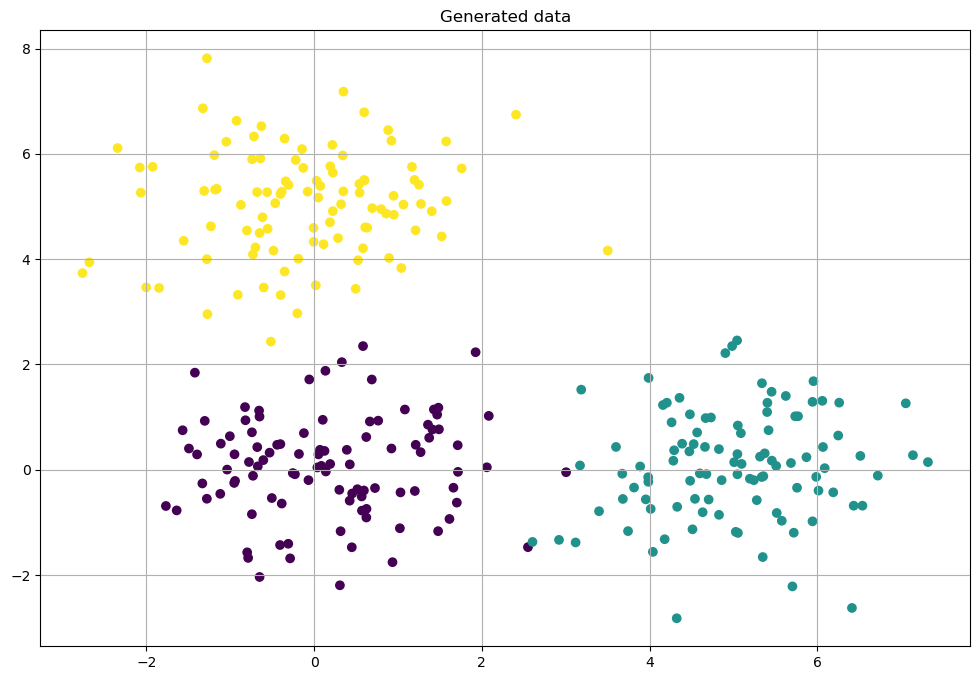

In [43]:
# generate K gaussian clusters of n samples
K = 3
nk = 100

samples = np.zeros((K*nk, 2))
clusters = np.zeros(K*nk)
ks = [0, 2, 1]

mus = np.array([[0, 0], [0, 5], [5, 0]])

for k in range(K):
    sigma = np.eye(2)
    x = np.random.multivariate_normal(mus[k], sigma, nk)
    samples[k*nk:(k+1)*nk] = x
    clusters[k*nk:(k+1)*nk] = ks[k]

plt.figure(figsize=(12,8))
plt.scatter(samples[:,0], samples[:,1], c=clusters, cmap='viridis')
plt.grid()
plt.title('Generated data')
plt.show()

2) Implement K-Means using the built-in methods from scikit-learn. You can use [this website](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) as a reference (by now you should be able to use scikit learn confidently). Plot the data points in the 2-dimensional space with their centroids and compare these to the predicted ones.

_Hint_: You can use *Kmeans.cluster_centers_* and *Kmeans.labels_* to extract the means and the variances resepectively

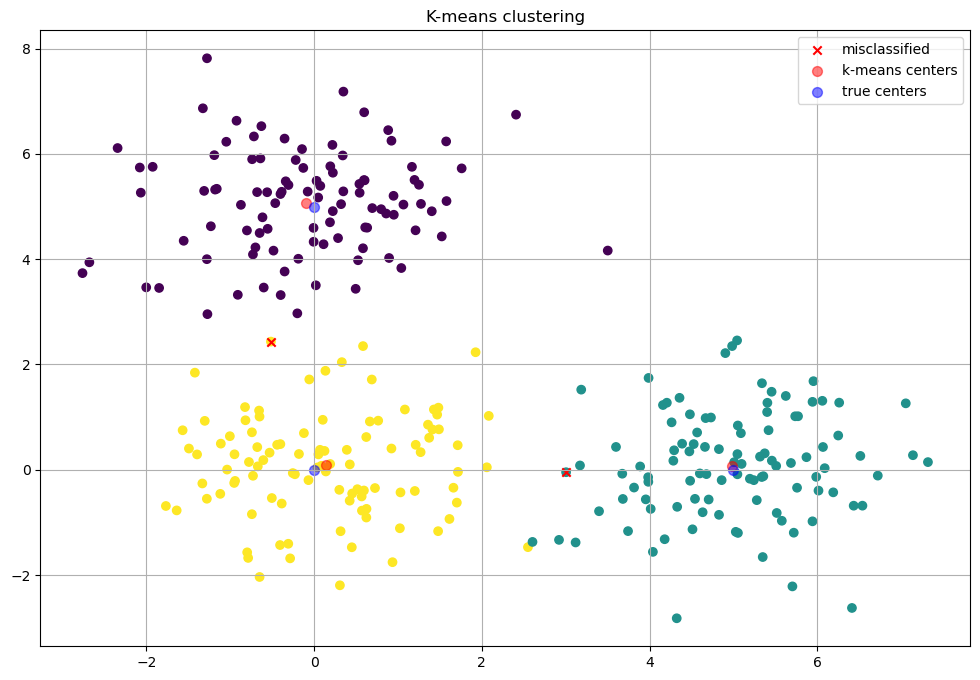

In [46]:
# do K-means clustering on the generated data
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=K, random_state=0).fit(samples)
kmeans_labels = kmeans.labels_
kmeans_centers = kmeans.cluster_centers_

misclassified = np.where(np.abs(kmeans_labels-2) != clusters)[0]

plt.figure(figsize=(12,8))
plt.scatter(samples[:,0], samples[:,1], c=kmeans_labels, cmap='viridis')
plt.scatter(samples[misclassified,0], samples[misclassified,1], marker='x', color='red', label='misclassified')
plt.scatter(kmeans_centers[:,0], kmeans_centers[:,1], c='red', s=50, alpha=0.5, label='k-means centers')
plt.scatter(mus[:,0], mus[:,1], c='blue', s=50, alpha=0.5, label='true centers')
plt.title('K-means clustering')
plt.legend()
plt.grid()
plt.show()

3) EVALUATED QUESTION: Vary the variance $\sigma$ of each cluster and plot the detected cluster again with their centroids and colors assigned according to cluster membership. In which way are the predictions affected when the noise level is higher?


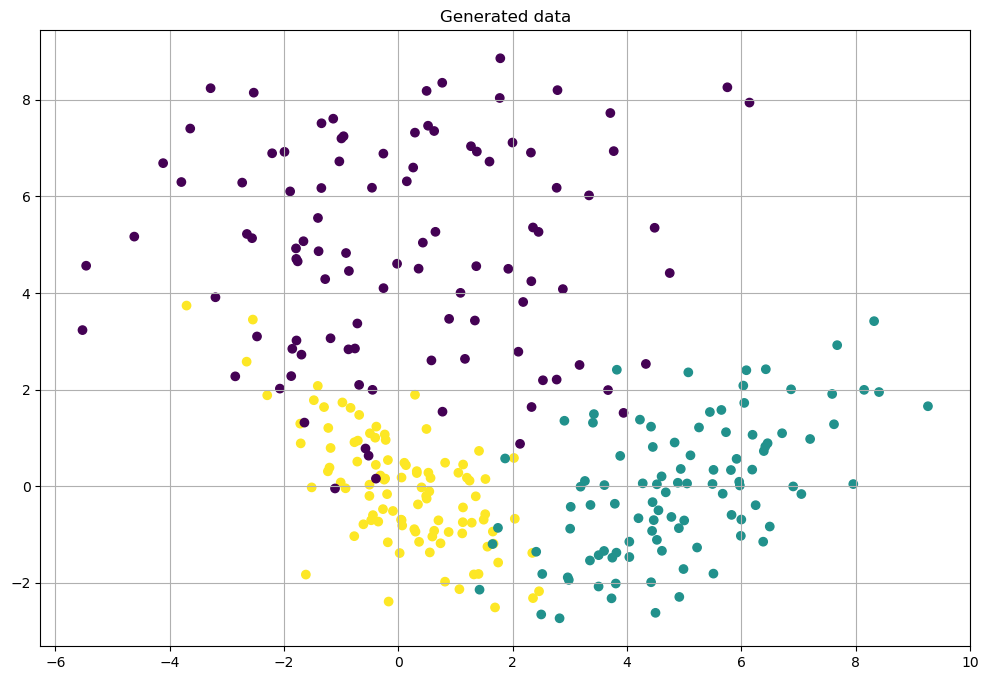

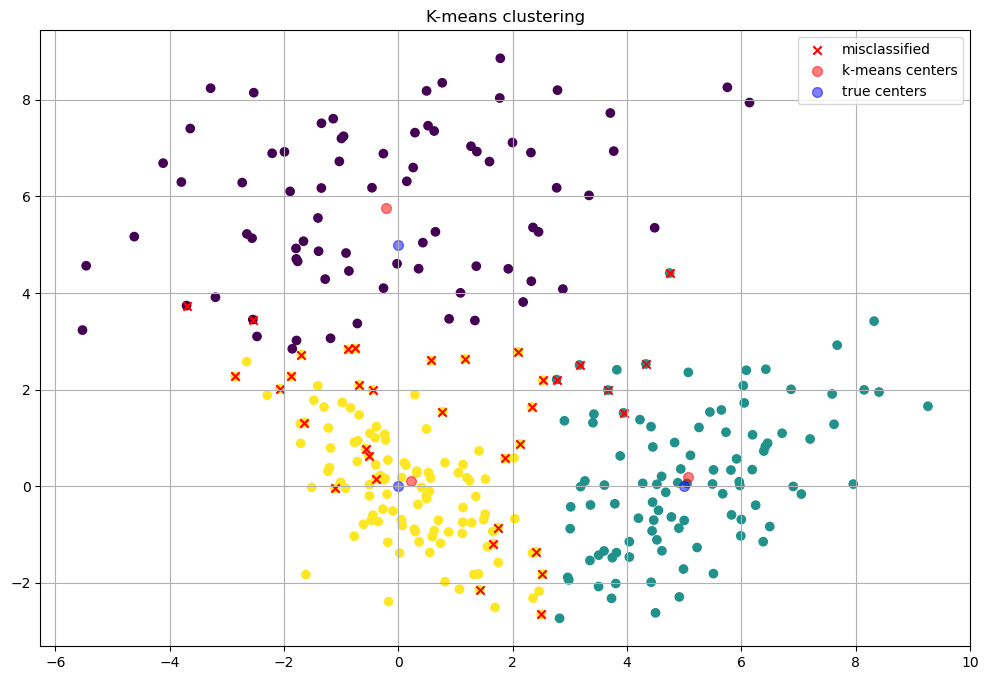

In [54]:
# vary the variance
ks = [2, 0, 1]
mus = np.array([[0, 0], [0, 5], [5, 0]])
sigmas = [2.5*np.eye(2)-np.ones((2, 2)), 5*np.eye(2), np.eye(2)+np.ones((2,2))]

for k in range(K):
    sigma = np.eye(2)
    x = np.random.multivariate_normal(mus[k], sigmas[k], nk)
    samples[k*nk:(k+1)*nk] = x
    clusters[k*nk:(k+1)*nk] = ks[k]

plt.figure(figsize=(12,8))
plt.scatter(samples[:,0], samples[:,1], c=clusters, cmap='viridis')
plt.grid()
plt.title('Generated data')
plt.show()

kmeans = KMeans(n_clusters=K, random_state=0).fit(samples)
kmeans_labels = kmeans.labels_
kmeans_centers = kmeans.cluster_centers_

misclassified = np.where(kmeans_labels != clusters)[0]

plt.figure(figsize=(12,8))
plt.scatter(samples[:,0], samples[:,1], c=kmeans_labels, cmap='viridis')
plt.scatter(samples[misclassified,0], samples[misclassified,1], marker='x', color='red', label='misclassified')
plt.scatter(kmeans_centers[:,0], kmeans_centers[:,1], c='red', s=50, alpha=0.5, label='k-means centers')
plt.scatter(mus[:,0], mus[:,1], c='blue', s=50, alpha=0.5, label='true centers')
plt.title('K-means clustering')
plt.legend()
plt.grid()
plt.show()

If we make the covariances larger, the generated clusters overlap more and thus the K-means algorithm is making more erors, if we have smaller covariance and thus more distinct clustes, the K-means algorithm performs very well. With higher noise (e.g. purple class) the centroids also drift further from the true means of the distribution. If we increase the variances even more and the data overlaps completely, the K-means algorithm fails to return meaningful clusters. Models like GMM or DBSCAN can provide better results for overlapping clusters.